E/N = 100 Td
Mean Energy 1 = 0.0942  eV
Mean Energy Inter-EEDF = 0.0948 eV
Mean Energy Final-EEDF = 0.0945 eV 

E/N = 195 Td
Mean Energy 1 = 0.1133  eV
Mean Energy Inter-EEDF = 0.1137 eV
Mean Energy Final-EEDF = 0.1136 eV 

E/N = 290 Td
Mean Energy 1 = 0.1576  eV
Mean Energy Inter-EEDF = 0.1399 eV
Mean Energy Final-EEDF = 0.1408 eV 

E/N = 385 Td
Mean Energy 1 = 0.3926  eV
Mean Energy Inter-EEDF = 0.2612 eV
Mean Energy Final-EEDF = 0.3525 eV 

E/N = 480 Td
Mean Energy 1 = 1.0146  eV
Mean Energy Inter-EEDF = 0.9098 eV
Mean Energy Final-EEDF = 1.1827 eV 

E/N = 575 Td
Mean Energy 1 = 1.8465  eV
Mean Energy Inter-EEDF = 1.8389 eV
Mean Energy Final-EEDF = 1.8008 eV 

E/N = 670 Td
Mean Energy 1 = 2.5907  eV
Mean Energy Inter-EEDF = 2.5923 eV
Mean Energy Final-EEDF = 2.6568 eV 

E/N = 765 Td
Mean Energy 1 = 3.1803  eV
Mean Energy Inter-EEDF = 3.1839 eV
Mean Energy Final-EEDF = 3.2902 eV 

E/N = 860 Td
Mean Energy 1 = 3.6545  eV
Mean Energy Inter-EEDF = 3.6557 eV
Mean Energy Final-EEDF = 3.81

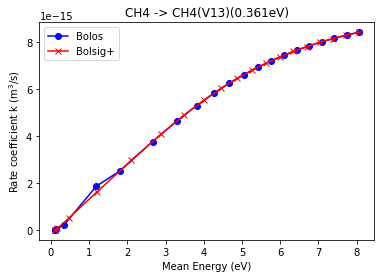

In [1]:
import numpy as np
import scipy.constants as co
import matplotlib.pyplot as plt
#import solver2
#from bolos import parser, grid
#from bolos import parser, grid, solver2
from bolosKhai import parser, grid, solver2
np.seterr(divide='ignore', invalid='ignore')
# Create an energy grid for Boltzmann Solver
# This energy grid has unit in eV
gr = grid.QuadraticGrid(0, 20, 200)
bsolver = solver2.BoltzmannSolver(gr)

# Import data file, which contains the cross section data.
with open('Cross Section.dat') as fp:
    processes = parser.parse(fp)
processes = bsolver.load_collisions(processes)
bsolver.target['CH4'].density = 0.5
bsolver.target['Ar'].density = 0.5

##################################################
# INPUT
bsolver.OmegaN = 0.10000E-11        # Omega / N
bsolver.kT = 400 * co.k / co.eV     # Gas - Temperature 400 K

# GUESS by Maxwell distribution function.
# Here we are starting with
# with an electron temperature of 6 eV
f0 = bsolver.maxwell(6.0)
mean_max = bsolver.mean_energy(f0)

def EEDF_AC(EN, f0):
    bsolver.grid = gr
    bsolver.EN = EN * solver2.TOWNSEND
    # After change any parameter we must initial the solver
    bsolver.init()
    f1 = bsolver.converge(f0, maxn=200, rtol=1e-4)
    mean1 = bsolver.mean_energy(f1)
    print('E/N = %.0f Td' % EN)
    print('Mean Energy 1 = %.4f  eV' % (mean1))

    # Get new grid
    newgrid = grid.QuadraticGrid(0, 10 * mean1, 200)
    bsolver.grid = newgrid
    bsolver.init()

    # Interpolate the previous EEDF over new grid
    f2 = bsolver.grid.interpolate(f1, gr)
    mean2 = bsolver.mean_energy(f2)

    # Find final EEDF
    f3 = bsolver.converge(f2, maxn=200, rtol=1e-5)
    mean3 = bsolver.mean_energy(f3)
    print('Mean Energy Inter-EEDF = %.4f eV' % mean2)
    print('Mean Energy Final-EEDF = %.4f eV \n'  % mean3)

    grid_EEDF = bsolver.cenergy
    return f3, grid_EEDF, mean3

# Range of Electric field / Number of electron - E0/N
# E = E0 * exp (i * Omega * t)
EN = np.linspace(100,2000,21)
rate1 = np.zeros_like(EN)
mean1 = np.zeros_like(EN)

plt.figure()
for i, ien in enumerate(EN):
    EEDF, gr_EEDF, mean1[i] = EEDF_AC(ien, f0)
    # We calculate the rate of reation : CH4 -> CH4(V13)(0.361eV)
    rate1[i] = bsolver.rate(EEDF, "CH4 -> CH4(V13)(0.361eV)")

#####################################################
### INPUT DATA BOLSIG+
input_file = 'CH4(V13)(0361eV)Bolsig.dat'
data = np.loadtxt(input_file)
x1 = data[:,0]
y1 = data[:,1]

###########################################
plt.plot(mean1, rate1, 'bo-' ,label = 'Bolos')
plt.plot(x1,y1,'rx-', label = 'Bolsig+')
plt.xlabel('Mean Energy (eV)')
plt.ylabel('Rate coefficient k (m$^\mathdefault{3}$/s)')
plt.title("CH4 -> CH4(V13)(0.361eV)")
plt.legend()
plt.show()